In [ ]:
# basic imports
import torch 
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from PIL import ImageOps, Image, ImageDraw
from skimage.util import random_noise


In [ ]:
# set up for dataset/loaders
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.set_printoptions(precision=2)

In [ ]:
# going to be using the MINST dataset w/ nothing special to start off
test_set = tv.datasets.MNIST('/files/', train=True, download=True)
train_data = DataLoader(tv.datasets.MNIST('/files/', train=True, download=True, transform=tv.transforms.ToTensor()), batch_size=batch_size)
test_data = DataLoader(tv.datasets.MNIST('/files/', train=False, download=True, transform=tv.transforms.ToTensor()),batch_size=batch_size)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


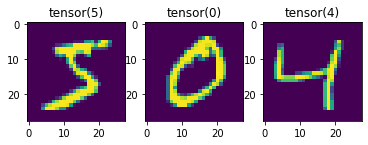

In [ ]:
# do a little test display to see what I'm working with here
example = enumerate(train_data)
batch_index, (batch_images, batch_labels) = next(example)

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(batch_images[i][0])
  plt.title(batch_labels[i])

plt.show()

In [ ]:
output_images = []

In [ ]:
def train(model, epochs, x_dataset, y_dataset):
  """
    Method used to train models 

    Parameters:
      - Model: The Model to train
      - Epochs: Number of Epochs/ Iterations to train for
      - train_dataset: The training dataset

    Returns:
      - losses: Array consisting of losses for each epoch
  """
  model.train()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  losses = []

  for e in range(epochs):
    best_train_loss = 100000
    train_loss = 0

    for index, ((x_image, x_label), (y_image, y_label)) in enumerate(zip(x_dataset, y_dataset)):
      x_image = x_image.float().cuda()
      y_image = y_image.float().cuda()

      optimizer.zero_grad()

      output = model(x_image)
      loss = criterion(output, y_image)

      loss.backward()
      optimizer.step()

      # purely for visualization purposes. Doing every next batch for each epoch since dataloaders are not shuffled 
      if index == e:
        visualizeBatch(x_image, output)

      train_loss += loss.item()

    # get average train loss
    train_loss /= len(train_data)
    losses.append(train_loss)
  
  return losses

In [ ]:
def validation(model, epochs, x_dataset, y_dataset):
  """
    Method used for validation

    Parameters:
      - model: The Model being tested
      - Epochs: Number of epochs used in when training. Used so the number of training losses match the number of testing losses

    Returns:
      - losses: Array consisting of losses 
  """
  model.eval()
  criterion = nn.MSELoss()
  losses = []

  spacing = len(test_data) // epochs

  with torch.no_grad():
    for index, ((x_image, label), (y_image, y_label)) in enumerate(zip(x_dataset, y_dataset)):
      if (index % spacing) == 0:
        x_image = x_image.float().to(device)
        y_image = y_image.float().to(device)

        o = model(x_image)

        loss = criterion(o, y_image)
        losses.append(loss.item())

        #visualizeBatch(x_image, o)
  
  return losses

In [ ]:
def visualizeBatch(input, output):
  """
    Method used to visualize reconstruction during training

    Parameters:
      - batch: The current batch of images to display
      - output: The output batch 
  """

  plt.figure(figsize=(5,2))

  for i, img in enumerate(input):
    # I only want to visualize 5 images 
    if i >= 4: break

    plt.subplot(2, 5, i+1)
    plt.imshow(img.cpu().detach()[0])

  for i, img in enumerate(output):
    if i >= 4: break
    
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(img.cpu().detach()[0])
  
  plt.show()

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
      super(Autoencoder, self).__init__()

      # encoding layer 
      self.encode = nn.Sequential(
          nn.Conv2d(1, 8, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(8, 16, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(16, 32, 3, padding=1),
          nn.ReLU()
      )

      # decoding layer
      self.decode = nn.Sequential(
          nn.ConvTranspose2d(32, 16, 3, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(16, 8, 3, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(8, 1, 3, padding=1),
          nn.Sigmoid()
      )

    # method for each forward 'pass' in the network
    def forward(self, x):
      x = x.float().cuda()
      x = self.encode(x)
      x = self.decode(x)

      return x

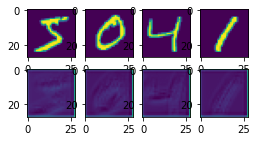

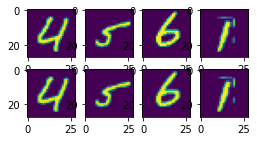

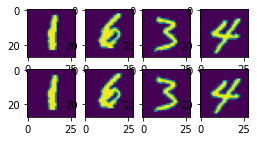

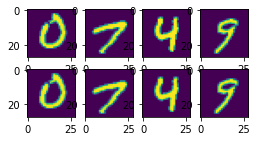

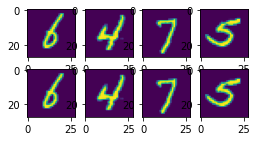

[4.61e-03 1.84e-04 1.30e-04 9.27e-05 5.82e-05]
[3.62e-05 3.88e-05 3.84e-05 4.45e-05 3.63e-05 4.35e-05]


In [ ]:
auto = Autoencoder().to(device)

num_epochs = 5

train_losses = train(auto, num_epochs, train_data, train_data)
test_losses = validation(auto, num_epochs, test_data, test_data)

print(np.array(train_losses))
print(np.array(test_losses))

In [ ]:
# instead of croping and re adding padding, creating a new image where pixels of the sub image don't match
# with the original, I'm just going to set all pixels outside of the sub image to 0 i.e black
class BetterSubImage(object):
  """
    - class used with Datasets to easily perform a custom transformation on each 
    - image in set
    - 
    - Each image is converted into a random sub image of itself
  """
  def __init__(self, percentage):
    self.percentage = percentage


  def __call__(self, image):
        img = np.array(image)

        height = img.shape[0]
        width = img.shape[1]

        delta_width = int(width*self.percentage)
        delta_height = int(height*self.percentage)

        x = np.random.randint(0, width - delta_width)
        y = np.random.randint(0, height - delta_height)

        img[:y] = 0
        img[:,:x] = 0 
        img[y+delta_height:] = 0
        img[:, x+delta_width:] = 0
        
        return img

In [ ]:
better_sub_image_loader = DataLoader(
    tv.datasets.MNIST(
        '/files/', train=True, download=True, transform=tv.transforms.Compose(
            [BetterSubImage(.6), tv.transforms.ToTensor()])), 
    batch_size=batch_size)

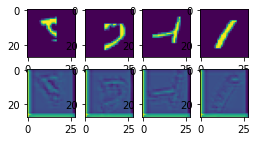

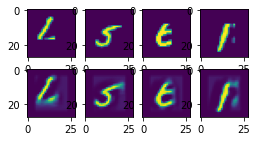

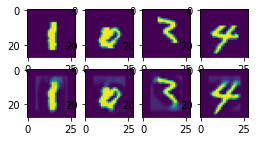

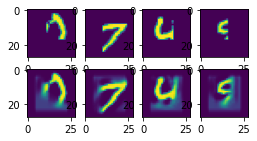

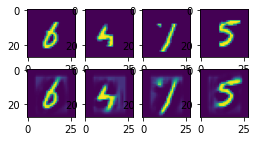

[0.03838487969103779, 0.02541232039766716, 0.022922794729757157, 0.02201033735981406, 0.02132812292992211]
[0.11041921377182007]


In [ ]:
sub_auto2 = Autoencoder().cuda()

train_losses = train(sub_auto2, num_epochs, better_sub_image_loader, train_data)
test_losses = validation(sub_auto2, 1, better_sub_image_loader, test_data)

print(train_losses)
print(test_losses)

In [ ]:
class SaltAndPepper(object):
  def __call__(self, image):
    image = torch.tensor(random_noise(image, mode="s&p", clip=True, salt_vs_pepper=.6))
    return image

In [ ]:
gaus_images = DataLoader(
    tv.datasets.MNIST(
        '/files/', train=True, download=True, transform=tv.transforms.Compose(
            [tv.transforms.GaussianBlur(5), tv.transforms.ToTensor(), SaltAndPepper()])), 
    batch_size=batch_size)

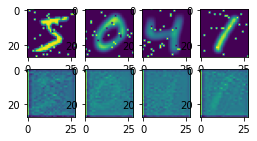

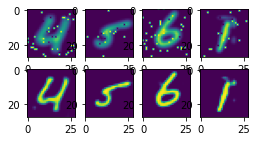

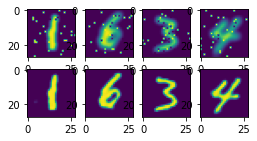

[0.012924970116224021, 0.0030268415079406424, 0.0024608352210626866]
[0.12230616062879562]


In [ ]:
gaus_auto = Autoencoder().cuda()

train_losses = train(gaus_auto, 3, gaus_images, train_data)
test_losses = validation(gaus_auto, 1, gaus_images, test_data)

print(train_losses)
print(test_losses)

In [ ]:
def recreation(sub_network, blur_network, x_data):
  sub_network.eval()
  blur_network.eval()

  with torch.no_grad():
    for index, (img, label) in enumerate(x_data):
      if (index % (len(x_data) // 4) ) == 0:
        img = img.float().to(device)

        sub_output = sub_network(img)
        blur_output = blur_network(sub_output)

        visualizeBatch(img, blur_output)

In [ ]:
# percentage_decrement = 5
# loaders = []

# for p in range(9, 10-percentage_decrement, -1):
#   loaders.append(DataLoader(
#     tv.datasets.MNIST(
#         '/files/', train=True, download=True, transform=tv.transforms.Compose(
#             [BetterSubImage(percentage=(p/10)), tv.transforms.ToTensor()])), 
#     batch_size=batch_size))

In [ ]:
# multiple_data_model = Autoencoder().cuda()
# tl = []
# for i in range(0,2):
#   for data in loaders:
#     tl.append(train(multiple_data_model, 1, data, train_data))

# print(tl)

In [ ]:
class AutoencoderT(nn.Module):
    def __init__(self):
      super(AutoencoderT, self).__init__()

      # encoding layer 
      self.encode = nn.Sequential(
          nn.Conv2d(1, 8, 3, padding=1), 
          nn.ReLU(),
          nn.MaxPool2d(2, stride=2),

          nn.Conv2d(8, 16, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, stride=2),

          nn.Conv2d(16, 32, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, stride=2),
          nn.ReLU()
      )

      # decoding layer
      self.decode = nn.Sequential(
          nn.ConvTranspose2d(32, 16, 2, stride=2),
          nn.ReLU(),

          nn.ConvTranspose2d(16, 8, 2, stride=2),
          nn.ReLU(),

          nn.ConvTranspose2d(8, 1, 2, stride=2),
          nn.Sigmoid()
      )

    # method for each forward 'pass' in the network
    def forward(self, x):
      x = x.float().cuda()
      x = self.encode(x)
      x = self.decode(x)

      return x

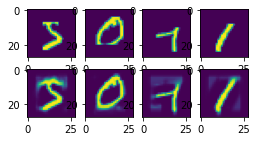

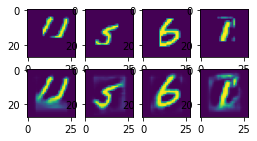

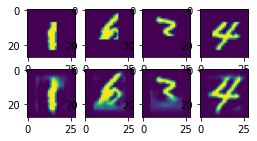

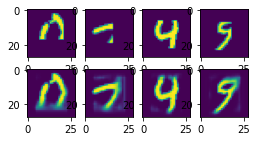

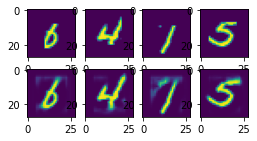

[0.019081793222099797, 0.019039952816731577, 0.019003310216976, 0.01892132752600795, 0.01884059885592222]
[0.10957390069961548]


In [ ]:
sub_auto3 = AutoencoderT().cuda()

train_losses = train(sub_auto2, num_epochs, better_sub_image_loader, train_data)
test_losses = validation(sub_auto2, 1, better_sub_image_loader, test_data)

print(train_losses)
print(test_losses)